# LANET (1.3): Adding Validation Loss

In [0]:
import numpy as np 
import pandas as pd
from sklearn import metrics

def loss(y_true, y_predicted, loss_function='mse'):
    if loss_function == 'mse':       
        return metrics.mean_squared_error( y_true, y_predicted)
    else:
        raise Exception('Loss metric is not defined.')

def get_dz_from_loss(y, y_predicted, metric):
    if metric == 'mse':
        return y_predicted - y
    else:
        raise Exception('Loss metric is not defined.')

def sigma(z, act_func):
    global _activation
    if act_func == 'relu':
       return np.maximum(z, np.zeros(z.shape))
    
    elif act_func == 'sigmoid':
      return 1.0/(1.0 + np.exp( -z ))

    elif act_func == 'linear':
        return z
    else:
        raise Exception('Activation function is not defined.')

def sigma_prime(z, act_func):
    if act_func == 'relu':
        return np.maximum(np.sign(z), np.zeros(z.shape)) # 1 if backward input >0, 0 otherwise; then diaganolize

    elif act_func == 'sigmoid':
        h = sigma(z, 'sigmoid')
        return h *(1-h)

    elif act_func == 'linear':
        return np.ones(z.shape)

    else:
        raise Exception('Activation function is not defined.')

def standardize(matrix):
    result = np.empty( matrix.shape )    
    # run through the cols    
    cols = matrix.shape[1]
    for i in range( cols ):
        col = matrix[:,i]

        mean = np.mean(col)
        std = np.std(col)

        # Handle std = 0 case
        if std < 1E-6:
          std = 1
            
        result[:,i] = np.array( (col - mean) / std  )

    return result


class Layer:
    def __init__(self,input_dim, output_dim, activation_function='linear'):    
        self.activation = activation_function
        self.input_dim = input_dim
        self.output_dim = output_dim 
        if input_dim > 0:
            self.b = np.random.randn( output_dim, 1 )       
            self.W = np.random.randn( output_dim, input_dim )
            self.dW = np.random.randn( output_dim, input_dim )
            self.db = np.random.randn( output_dim, 1 )          
        self.a = np.zeros( (output_dim,1) )

    
    def set_weight(self, W ):
        self.W = W
      
    def set_bias(self, b ):
        self.b = b
  
    def compute_activation(self, a ): 
        self.z =  np.add( np.dot(self.W, a), self.b)
        self.a =  sigma(self.z, self.activation)
    
    
    def print( self ):      
        print(f"\n====== Layer Info =======")
        print(f"a    = {self.a}")
        if self.input_dim > 0: 
          print(f"W   =  {self.W}")          
          print(f"b   =  {self.b}")  
    

class Model:
    def __init__(self, input_dim):  
        self.neural_net = []
        self.neural_net.append(Layer(0 , input_dim, 'irrelevant'))    
        self.history = []  
 
          
    def fit(self, training_data, epochs, val_data = None, early_stop=-1,  learning_rate=0.005, verbose=1 ):
      self.learning_rate = learning_rate
      self.history = []  
      
      X_train, y_train = training_data

      if val_data:
        X_valid, y_valid = val_data

      num_train_datum = X_train.shape[1]

      print(f"\n\nStart training for following parameters :")
      print(f" N              =  {num_train_datum}")
      if val_data:
          print(f" N for Val Data =  {X_valid.shape[1]}")
      else:
          print(f" No validation data provided")  
      print(f" Shape of X     =  {X_train.shape}")
      print(f" Shape of y     =  {y_train.shape}")
      print(f" epochs         =  {epochs}")
      print(f" learning_rate  =  {learning_rate}")
      print(f" early_stop     =  {early_stop}")
    
      
      # Training Loop
      last_loss = 1E20
      for epoch in range(1,epochs+1): 

          y_train_predicted = model.forward_propagation( X_train )
          self.backward_propagation( y_train, y_train_predicted, num_train_datum, verbose = verbose - 1 )
          self.update( learning_rate )
                                     
          # After backpropagation
          # ... calculate the training loss
          y_train_predicted = model.forward_propagation( X_train )
          training_loss   = loss(y_train, y_train_predicted)

          # Sanity Check: Is loss actually going down?
          if (training_loss < last_loss):
              last_loss = training_loss
          else:
            #  print(f"Warning: Loss is increasing after epoch {epoch}: {training_loss - last_loss}")
              last_loss = training_loss

          # ... calculate the validation loss ( if applicable)          
          if val_data:
            y_valid_predicted = model.forward_propagation( X_valid )
            validation_loss   = loss(y_valid, y_valid_predicted)
          else:
            validation_loss = -1

          # ... add result to the histoty
          self.history.append( [epoch, training_loss, validation_loss])

          # ...and finally check, if early_stop applies
          if (epoch > 10)  and (early_stop > 0):            
            past_loss   = self.history[epoch-6][1] 
            if (abs(training_loss - past_loss)) < early_stop:
              print(f"Early stop in after epoch {epoch} with training-loss  {training_loss}")
              print(f"Early stop in after epoch {epoch} with validation-loss  {validation_loss}")          
              print(f"   Prev Loss ({epoch-5}) : {past_loss} [Delta: { abs(training_loss-past_loss) }]")
              break   
            
          # If requested, print result of this round
          if (verbose > 0):
            print(f"Epoch {epoch}: Train.-Loss   = { training_loss  }")
            print(f"Epoch {epoch}: Val-Loss      = { validation_loss  }")
            print(f"Epoch {epoch}: Finished")

          ##### end of fit loop 
      return (training_loss, validation_loss)


    def add_layer(self, nr_neurons, activation='relu'):    
        layer_index = len(self.neural_net)
        input_dim = self.neural_net[layer_index - 1].output_dim
        new_layer = Layer( input_dim, nr_neurons, activation)
        self.neural_net.append( new_layer )


    def forward_propagation(self, input_vec ):
        self.neural_net[0].a = input_vec
        for layer_index in range(1,len(self.neural_net)):    
            _A_Prev = self.neural_net[layer_index-1].a                       
            self.neural_net[layer_index].compute_activation( _A_Prev )
        return  self.neural_net[layer_index].a
  
    def backward_propagation(self, y, y_predicted, num_train_datum, metric='mse', verbose=0):   
            nr_layers = len(self.neural_net)
            for layer_index in range(nr_layers-1,0,-1):
                if layer_index+1 == nr_layers: # if output layer

                    dz = np.multiply(get_dz_from_loss(y, y_predicted, metric), 
                                    sigma_prime(
                                        self.neural_net[layer_index].a, 
                                        self.neural_net[layer_index].activation)
                    )        
                else: 
                    dz = np.multiply(
                          np.dot(
                              self.neural_net[layer_index+1].W.T, 
                              dz), 
                          sigma_prime(
                                self.neural_net[layer_index].a, 
                                self.neural_net[layer_index].activation)
                          )         
                dW = np.dot(dz, self.neural_net[layer_index-1].a.T) / num_train_datum
                db = np.sum(dz, axis=1, keepdims=True) / num_train_datum

                # Update gradients
                self.neural_net[layer_index].dW = dW 
                self.neural_net[layer_index].db = db 

                if (verbose > 0):
                  print(f"\n\n====== Backward Propagation Layer {layer_index} =======")
                  print(f"dZ      =  {dz}")          
                  print(f"dW      =  {dW}")
                  print(f"db      =  {db}")
                  print(f"A           = {self.neural_net[layer_index].a}") 
                  print(f"A prev lay  = {self.neural_net[layer_index-1].a}") 
                  

    def update( self, learning_rate ):
        nr_layers = len(self.neural_net)
        for layer_index in range(1,nr_layers):        
            self.neural_net[layer_index].set_weight( self.neural_net[layer_index].W - learning_rate * self.neural_net[layer_index].dW )
            self.neural_net[layer_index].set_bias(  self.neural_net[layer_index].b  - learning_rate * self.neural_net[layer_index].db  )
    

    def get_history(self):
            return pd.DataFrame(
                self.history, 
                columns=['epoch', 'training_loss', 'validation_loss']
            )   

    def summary(self):
        print("MODEL SUMMARY")
        for layer_index in range(len(self.neural_net)):        
          self.neural_net[layer_index].print()
          
        print("FINISHED MODEL SUMMARY")

# Testing

## Import the AUTO-MPG Dataloader

In [0]:
def load_auto_mpg_data(samples = -1):
  df = pd.read_csv(
      "https://data.heatonresearch.com/data/t81-558/auto-mpg.csv", 
      na_values=['NA', '?'])


  print( df.describe() )

  # Handle the missing values
  df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())

  nCyl = df['cylinders']
  nDis = df['displacement']
  nHor = df['horsepower']
  nWei = df['weight']
  nAcc = df['acceleration']
  nYea = df['year']
  nOri = df['origin']

  X = pd.concat( [nCyl, nDis, nHor, nWei, nAcc, nYea, nOri], axis = 'columns').values;
  y_true = np.array( [ df['mpg'].values ] ).T # regression

  if (samples < 0 ):
    return (X, y_true)
  else:
    return ( X[0:samples,:], y_true[0:samples,:])

## Run Test

              mpg   cylinders  ...        year      origin
count  398.000000  398.000000  ...  398.000000  398.000000
mean    23.514573    5.454774  ...   76.010050    1.572864
std      7.815984    1.701004  ...    3.697627    0.802055
min      9.000000    3.000000  ...   70.000000    1.000000
25%     17.500000    4.000000  ...   73.000000    1.000000
50%     23.000000    4.000000  ...   76.000000    1.000000
75%     29.000000    8.000000  ...   79.000000    2.000000
max     46.600000    8.000000  ...   82.000000    3.000000

[8 rows x 8 columns]


Start training for following parameters :
 N              =  318
 N for Val Data =  80
 Shape of X     =  (7, 318)
 Shape of y     =  (1, 318)
 epochs         =  100000
 learning_rate  =  0.001
 early_stop     =  1e-05
Early stop in after epoch 33653 with training-loss  5.620096518473308
Early stop in after epoch 33653 with validation-loss  7.438610330663948
   Prev Loss (33648) : 5.620095352334804 [Delta: 1.1661385039829497e-06]
       epoc

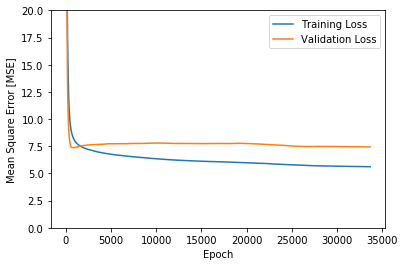

,pred,y
308,13.800901,14.0
309,16.412647,18.0
310,29.228856,32.0
311,33.770177,31.9
312,18.332350,19.2
313,32.318719,31.5
314,13.306663,14.0
315,36.538067,29.8
316,13.748103,15.0
317,31.952502,29.5


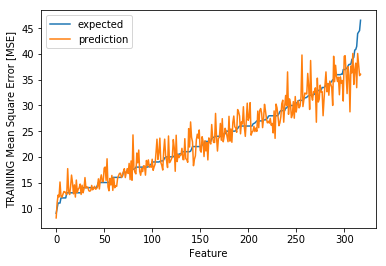

,pred,y
70,13.448213,16.0
71,19.601936,19.0
72,26.363160,23.0
73,20.091074,19.0
74,35.527415,33.8
75,27.804668,25.4
76,35.688234,43.4
77,34.212713,32.4
78,20.789468,21.5
79,13.464949,14.0


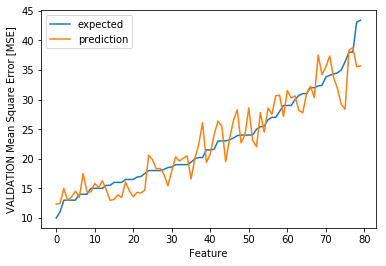

In [57]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

input_dim = 7
output_dim = 1
model = Model( input_dim )
model.add_layer( 10, 'relu' )
model.add_layer( output_dim, 'linear' )

(X, y_true ) = load_auto_mpg_data()


#Scaling
standardizer = Standardizer()
X_S = standardize( X )

epochs  = 100000
learning_rate = 0.001
early_stop = 1E-5
test_size = 0.2


X_train, X_test, y_train, y_test = train_test_split(    
    X_S, y_true, test_size= test_size)

model.fit( (X_train.T, y_train.T), epochs, (X_test.T, y_test.T), early_stop= early_stop, learning_rate = learning_rate , verbose=0)
history = model.get_history()
print( history.tail(10))

plt.figure()
plt.plot(history['training_loss'], label='Training Loss')
plt.plot(history['validation_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [MSE]')
plt.ylim([0,20])  
plt.legend()
plt.show()
      

plt.figure()
t = pd.DataFrame({'pred': model.forward_propagation(X_train.T).flatten() , 'y': y_train.T.flatten()})
display( t.tail(10) )
t.sort_values(by=['y'], inplace=True)
plt.plot(t['y'].tolist(), label='expected')
plt.plot(t['pred'].tolist(), label='prediction')
plt.xlabel('Feature')
plt.ylabel('TRAINING Mean Square Error [MSE]')
plt.legend()
plt.show()


plt.figure()
t = pd.DataFrame({'pred': model.forward_propagation(X_test.T).flatten() , 'y': y_test.T.flatten()})
display( t.tail(10) )
t.sort_values(by=['y'], inplace=True)
plt.plot(t['y'].tolist(), label='expected')
plt.plot(t['pred'].tolist(), label='prediction')
plt.xlabel('Feature')
plt.ylabel('VALDATION Mean Square Error [MSE]')
plt.legend()
plt.show()
